### Singapore Covid-19 Incident Cases Prediction

Author: Rajendran Kaviya, Date: 25 June 2022

In [31]:
# imports
import numpy as np
import pandas as pd
import statsmodels as sm
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.ar_model import AutoReg
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

### Load Data

The dataset was downloaded from https://ourworldindata.org/coronavirus/country/singapore on 25 June 2022. It contains information about Covid-19 incident cases, total cases, deaths etc in all countries. We are interested in forecasting incident cases in Singapore, so we load the dataset and extract data relevant to Singapore.

In [32]:
# load data and view
df = pd.read_csv('covid-19/owid-covid-data.csv')
df_sg = df[df['location']=='Singapore']
df_sg.head()

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million
158241,SGP,Asia,Singapore,2020-01-23,1.0,1.0,NaN,NaN,NaN,NaN,...,5.2,28.3,NaN,2.4,83.62,0.938,NaN,NaN,NaN,NaN
158242,SGP,Asia,Singapore,2020-01-24,3.0,2.0,NaN,NaN,NaN,NaN,...,5.2,28.3,NaN,2.4,83.62,0.938,NaN,NaN,NaN,NaN
158243,SGP,Asia,Singapore,2020-01-25,3.0,0.0,NaN,NaN,NaN,NaN,...,5.2,28.3,NaN,2.4,83.62,0.938,NaN,NaN,NaN,NaN
158244,SGP,Asia,Singapore,2020-01-26,4.0,1.0,NaN,NaN,NaN,NaN,...,5.2,28.3,NaN,2.4,83.62,0.938,NaN,NaN,NaN,NaN
158245,SGP,Asia,Singapore,2020-01-27,5.0,1.0,NaN,NaN,NaN,NaN,...,5.2,28.3,NaN,2.4,83.62,0.938,NaN,NaN,NaN,NaN


### Exploratory data analysis

It is always useful to visualize the time series with a simple line plot, to gauge the type of time series data we are dealing with. Typically, time series data have a some combination of a mean value, trend, seasonal pattern and cyclical pattern or all of it.

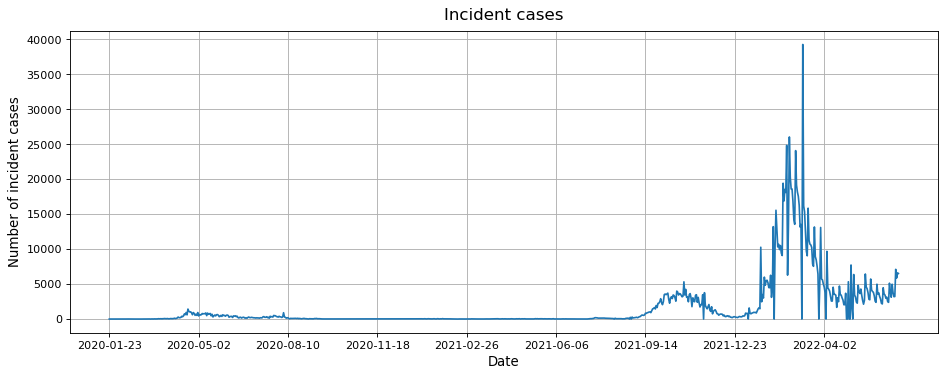

In [33]:
cases = df_sg['new_cases'].values
dates = df_sg['date'].values
plt.figure(figsize=(14, 5), dpi=80)
plt.title("Incident cases", fontsize=15, pad=10.0)
plt.plot(dates, cases)
plt.xticks(np.arange(0, len(cases), step=100))
plt.ylabel("Number of incident cases", fontsize=12)
plt.xlabel("Date", fontsize=12)
plt.grid()

We see a clear change in trend as years pass. We see that the number of incident cases are fairly low till Sep 2021, and start blowing up around Jan 2022. However, the trend change is not linear or structured. This time series is highly dynamic, fluctuating data that is probably influenced by various exogenous variables.

In order to better understand the time series, we can decompose it with 'seasonal_decompose'.

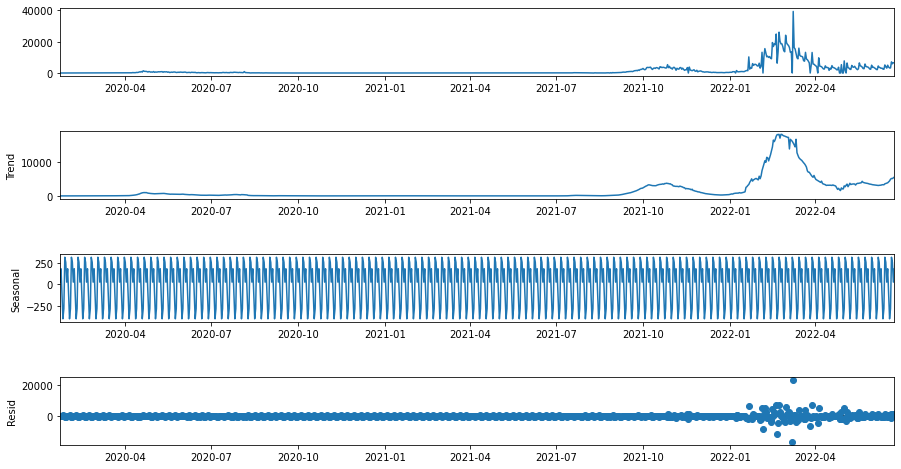

In [34]:
tsd = pd.to_datetime(df_sg.loc[:,'date']) # convert to time series date (reqd for seasonal_decompose)
df_sg.insert(loc=0, column='time_series_date', value=tsd)
df_cases = df_sg.set_index("time_series_date")[['new_cases']]

decomposition = seasonal_decompose(df_cases, model='additive',extrapolate_trend='freq')
fig = decomposition.plot()
fig.set_size_inches(14,7)
plt.show()

We see the clear change in mean in the 'trend' plot. The 'seasonal' plot indicates that there is a repeated cyclic pattern in the time series. The 'resid' plot shows fairly random and constant residue for most of the time series, except in 2022. This means that there is alot of fluctuation in this time period, that will potentially be hard to predict with a model.

Let's look at the time series in close up, over a 15-week window.

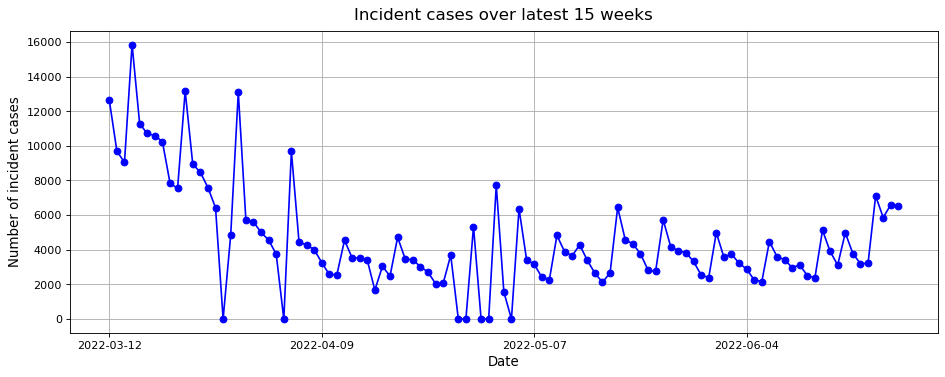

In [37]:
plt.figure(figsize=(14, 5), dpi=80)
plt.title("Incident cases over latest 15 weeks", fontsize=15, pad=10.0)
plt.plot(dates[-(15*7):], cases[-(15*7):], 'bo-')
plt.xticks(np.arange(0, len(cases[-(15*7):]), step=28))
plt.ylabel("Number of incident cases", fontsize=12)
plt.xlabel("Date", fontsize=12)
plt.grid()

In this plot, the cyclic pattern (seasonality component) is clearer. There is a spike in incident cases after every weekend, which is expected since close contact crowds occur extensively over weekends.

### A note about stationarity

This time series is very obviously not stationary, so there is no need to do an ADF test. The general practice is to remove the stationarity in the time series by detrending and differencing, and then proceed with fitting a model. However, it is impractical to employ this method with the entire time series, as there are huge fluctuations in the data over 2.5 years. Old data (from 1 year ago) could be completely irrelevant for current forecasts. It is more practical to consider shorter time segments [1] (more details below).

### A note about model selection and model training procedure

In [1], the authors propose an ensemble method for incident cases prediction, where the weighted average of forecasts from multiple models is used to get a better overall forecast. One of the models used in the ensemble is ARMA. 

The authors propose to perform a log-transform (to nullify large fluctuations in variance) and then train an ARMA model over a short segment (eg. 8 weeks), with the **assumption** that the incident cases are relatively stationary over that segment. Then a forecast is constructed for the week ahead (the paper considers 4 weeks ahead, but we stick to 1 in this work, for now). After the week passes, the newly acquired data for the latest week is added to the training data, and the oldest week in the training data is dropped. Then the model is retrained over this new segment. This process is repeated every week.

The authors also use an ARIMA model (which can handle non-stationarity) in the ensemble, in case the above assumption is false.

We first explore the ARMA model for this time series and use the ARMA model training method in [1], as described above. This means that the length of training segment (x no. of weeks) and the ARMA model parameters (p,q) need to be tuned with cross-validation.

### Next steps:
<br>1) Cross-validation to determine hyper-parameters
<br>2) Model training with optimal hyper-parameters
<br>3) Model evaluation with test data (future weeks after 25 June) - can be evaluated against the actual incident cases in future weeks

### References

[1] A. Adiga et al., "All Models Are Useful: Bayesian Ensembling for Robust High Resolution COVID-19 Forecasting", 2021. Available: 10.1101/2021.03.12.21253495 [Accessed 26 June 2022] https://dl.acm.org/doi/pdf/10.1145/3447548.3467197